In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nsepy import get_history
%matplotlib inline
from datetime import date, timedelta, datetime

In [49]:
# Initialising the number of years of training data to be downloaded from NSE
training_no_of_years = 12
# Initialising start and end dates for stock data download
start_date = date.today() - timedelta(days = 365*training_no_of_years + training_no_of_years//4) #adjusting no of days for leap years in between
end_date = date.today()

<AxesSubplot:xlabel='Date'>

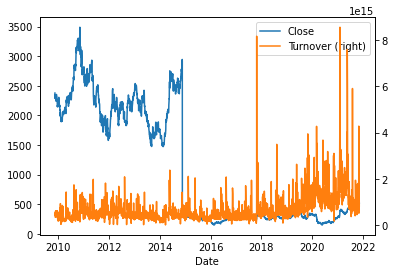

In [50]:
# Stock selected is State Bank of India (NSE: SBIN), the largest bank in India and one of the most liquid stocks
stockdf = get_history(symbol = 'SBIN', start = start_date, end = end_date)
stockdf[['Close', 'Turnover']].plot(secondary_y='Turnover')

In [51]:
stockdf = stockdf.drop(['Trades', 'Turnover'], axis=1)

In [52]:
stockdf.tail(3)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,
2021-11-08,SBIN,EQ,530.45,534.45,534.45,516.45,523.6,523.25,524.29,36802110,13809608,0.3752
2021-11-09,SBIN,EQ,523.25,526.25,532.00,522.20,529.0,529.15,528.31,25451967,10868864,0.4270
2021-11-10,SBIN,EQ,529.15,525.55,528.50,521.50,523.7,524.40,524.92,15805538,6661421,0.4215


In [53]:
stockdf.describe() # result shows that the stock data is not adjusted for a 1:10 split


,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
count,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2.980000e+03,2.980000e+03,2980.000000
mean,1098.693272,1099.396477,1113.594128,1083.981963,1097.857215,1098.078742,1099.024594,1.746150e+07,4.935789e+06,0.312675
std,994.172670,994.961581,1007.455425,981.617927,993.634870,993.971152,994.750804,2.243628e+07,6.000052e+06,0.102498
min,150.850000,151.950000,153.200000,148.250000,151.100000,150.850000,151.820000,8.841100e+04,1.799700e+04,0.083700
25%,268.537500,268.900000,272.000000,265.637500,268.787500,268.537500,268.857500,2.139100e+06,6.758570e+05,0.236000
50%,338.175000,338.450000,344.175000,333.450000,338.400000,338.175000,338.900000,1.143689e+07,3.496605e+06,0.303700
75%,2117.950000,2124.225000,2149.150000,2093.912500,2115.500000,2117.150000,2124.850000,2.259668e+07,7.097378e+06,0.381400
max,3489.950000,3505.000000,3515.000000,3451.350000,3499.000000,3489.950000,3485.250000,2.626771e+08,1.333311e+08,0.716200


In [54]:
#Adjusting stock closing prices for splits of 1:10
stockdf['Close'] = stockdf['Close'].apply(lambda x:x/10 if x>1000 else x)

In [55]:
# Forming a 2-d array of closing prices to be fed into RNN
# We take the last 20 day prices in the test data (corresponding roughly to 1 calendar month)
trend_test_days = 20
training_set = stockdf.iloc[:len(stockdf)-trend_test_days,7:8].values


In [56]:
training_set, len(training_set)


(array([[237.825],
        [229.365],
        [229.99 ],
        ...,
        [457.9  ],
        [458.   ],
        [469.25 ]]),
 2960)

In [57]:
# Using normalisation to scale data, as RNN uses distance between data points to train 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [58]:
# The recurrent neural network with long short term memory (LSTM) will use a timestep of 120 trading days as memory
# Creating the data structure which preserves 120 days of memory
X_train = [] #initiate training lists
y_train = []
memory_range = 120
for i in range(memory_range, len(training_set_scaled)):
    X_train.append(training_set_scaled[(i - memory_range):i,0])
    y_train.append(training_set_scaled[i,0])

#Convert the lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [59]:
X_train.shape, y_train.shape

((2840, 120), (2840,))

In [60]:
# reshape the x_train array to fit the shape expected by RNN algorithm
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2840, 120, 1)

In [61]:
# Importing the RNN libraries and classes
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [62]:
#Initialise the regressor object of class Sequential
regressor = Sequential()

In [63]:
#Building the RNN architecture with dropout regularisation
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = False)) # last LSTM layer should have return sequence as False
regressor.add(Dropout(0.2))
#Adding the output layer
regressor.add(Dense(units = 1))

In [64]:
#Compile the recurrent neural network
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [65]:
#Fitting the RNN model on training data
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
89/89 [==============================] - 23s 192ms/step - loss: 0.0109
Epoch 2/100
89/89 [==============================] - 17s 186ms/step - loss: 0.0047
Epoch 3/100
89/89 [==============================] - 16s 177ms/step - loss: 0.0041
Epoch 4/100
89/89 [==============================] - 16s 180ms/step - loss: 0.0036
Epoch 5/100
89/89 [==============================] - 16s 182ms/step - loss: 0.0034
Epoch 6/100
89/89 [==============================] - 16s 178ms/step - loss: 0.0030
Epoch 7/100
89/89 [==============================] - 16s 179ms/step - loss: 0.0028
Epoch 8/100
89/89 [==============================] - 18s 202ms/step - loss: 0.0024
Epoch 9/100
89/89 [==============================] - 17s 188ms/step - loss: 0.0024
Epoch 10/100
89/89 [==============================] - 17s 186ms/step - loss: 0.0022
Epoch 11/100
89/89 [==============================] - 16s 180ms/step - loss: 0.0022
Epoch 12/100
89/89 [==============================] - 15s 168ms/step - loss: 0.0023
E

89/89 [==============================] - 18s 198ms/step - loss: 6.9433e-04
Epoch 96/100
89/89 [==============================] - 15s 172ms/step - loss: 6.8977e-04
Epoch 97/100
89/89 [==============================] - 17s 187ms/step - loss: 7.6492e-04
Epoch 98/100
89/89 [==============================] - 17s 194ms/step - loss: 7.0517e-04
Epoch 99/100
89/89 [==============================] - 17s 190ms/step - loss: 7.1445e-04
Epoch 100/100
89/89 [==============================] - 17s 187ms/step - loss: 8.2086e-04


In [66]:
test_set = stockdf.iloc[len(stockdf) - memory_range - trend_test_days:,7:8].values
test_set = scaler.transform(test_set)
test_set.shape

(140, 1)

In [67]:
# preparing the test input data structure
X_test = []
for i in range(memory_range, memory_range + trend_test_days):
    X_test.append(test_set[i - memory_range:i, 0])
X_test = np.array(X_test)

In [68]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(20, 120, 1)

In [69]:
# Predict stock prices for the last 20 days
predicted_stock_prices = regressor.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

In [70]:
# Get actual stock prices for comparison of trend prediction
actual_stock_prices = stockdf.iloc[len(stockdf) - trend_test_days:,7:8].values
actual_stock_prices.shape, predicted_stock_prices.shape

((20, 1), (20, 1))

In [71]:
# Get data in dataframe format with added accuracy measures
final_stock_pred = pd.DataFrame(data = actual_stock_prices, columns = ['actual_stock_prices'])
final_stock_pred = pd.concat((final_stock_pred, pd.DataFrame(data = predicted_stock_prices, columns = ['predicted_stock_prices'])), axis=1)

In [72]:
final_stock_pred['actual_change'] = np.zeros(len(final_stock_pred))
final_stock_pred['predicted_change'] = np.zeros(len(final_stock_pred)) 

for i in range(0,len(final_stock_pred)-1):
    final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
    final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()
    final_stock_pred['pred_accuracy'] = final_stock_pred['actual_change'] - final_stock_pred['predicted_change']

final_stock_pred['actual_change'] = (final_stock_pred['actual_change']*100).round(2)
final_stock_pred['predicted_change'] = (final_stock_pred['predicted_change']*100).round(2)
final_stock_pred['pred_accuracy'] = (final_stock_pred['pred_accuracy']*100).round(2)

<ipython-input-72-7d46325dd514>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
<ipython-input-72-7d46325dd514>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()


In [73]:
final_stock_pred['%_price_diff'] = (((final_stock_pred['actual_stock_prices']-final_stock_pred['predicted_stock_prices'])/final_stock_pred['actual_stock_prices'].mean())*100).round(2)
print(final_stock_pred)
print('Average Prediction Accuracy: ',(final_stock_pred['pred_accuracy'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')
print('Average Price Difference between Actual & Predicted: ',(final_stock_pred['%_price_diff'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')

    actual_stock_prices  predicted_stock_prices  actual_change  \
0                483.00              462.064148           0.00   
1                481.70              470.451263          -0.26   
2                490.60              471.202057           1.75   
3                497.95              478.940979           1.45   
4                488.20              484.278564          -1.92   
5                499.90              480.871185           2.30   
6                502.95              489.056213           0.60   
7                502.95              490.674255           0.00   
8                506.50              492.230927           0.70   
9                512.55              495.423096           1.19   
10               519.15              499.039215           1.30   
11               501.35              503.297211          -3.50   
12               502.15              496.110016           0.16   
13               515.70              497.370270           2.67   
14        

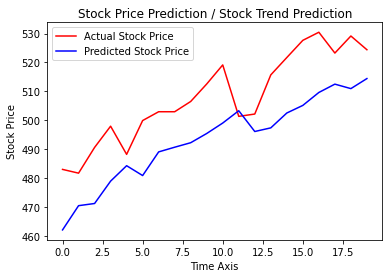

In [74]:
plt.plot(final_stock_pred['actual_stock_prices'], color = 'red', label = 'Actual Stock Price')
plt.plot(final_stock_pred['predicted_stock_prices'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction / Stock Trend Prediction')
plt.xlabel('Time Axis')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

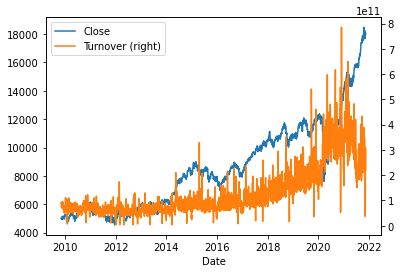

In [75]:
nifty = get_history(symbol="NIFTY", 
                    start=start_date, 
                    end=end_date,
                    index=True)
nifty[['Close', 'Turnover']].plot(secondary_y='Turnover')

In [76]:
nifty.tail(3)

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2021-11-08,18040.20,18087.80,17836.10,18068.55,338919483.0,3.090823e+11
2021-11-09,18084.35,18112.60,17983.05,18044.25,270197527.0,2.368609e+11
2021-11-10,17973.45,18061.25,17915.00,18017.20,261446523.0,2.228111e+11


In [77]:
nifty.describe() # result shows that the stock data is not adjusted for a 1:10 split

,Open,High,Low,Close,Volume,Turnover
count,2977.000000,2977.000000,2977.000000,2977.000000,2.976000e+03,2.976000e+03
mean,8582.130702,8626.159674,8523.276839,8575.431323,2.660420e+08,1.252058e+11
std,3062.524815,3071.020963,3044.523520,3058.769337,1.934617e+08,9.574429e+10
min,4623.150000,4623.150000,4531.150000,4544.200000,6.555703e+06,2.978900e+09
25%,5824.200000,5861.300000,5776.950000,5826.050000,1.469322e+08,6.319030e+10
50%,8202.650000,8242.400000,8148.600000,8201.050000,1.907994e+08,8.390440e+10
75%,10708.750000,10757.800000,10635.650000,10696.200000,3.034693e+08,1.544292e+11
max,18602.350000,18604.450000,18445.300000,18477.050000,1.811564e+09,7.852293e+11


In [78]:
# Forming a 2-d array of closing prices to be fed into RNN
# We take the last 20 day prices in the test data (corresponding roughly to 1 calendar month)
trend_test_days = 20
training_set = nifty.iloc[:len(nifty)-trend_test_days,7:8].values


In [79]:
training_set, len(training_set)

(array([], shape=(2957, 0), dtype=float64), 2957)

In [80]:
# Using normalisation to scale data, as RNN uses distance between data points to train 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

ValueError: Found array with 0 feature(s) (shape=(2957, 0)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
# The recurrent neural network with long short term memory (LSTM) will use a timestep of 120 trading days as memory
# Creating the data structure which preserves 120 days of memory
X_train = [] #initiate training lists
y_train = []
memory_range = 120
for i in range(memory_range, len(training_set_scaled)):
    X_train.append(training_set_scaled[(i - memory_range):i,0])
    y_train.append(training_set_scaled[i,0])

#Convert the lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
# reshape the x_train array to fit the shape expected by RNN algorithm
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
#Fitting the RNN model on training data
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

In [ ]:
test_set = nifty.iloc[len(nifty) - memory_range - trend_test_days:,5:8].values
test_set = scaler.transform(test_set)
test_set.shape

In [ ]:
# preparing the test input data structure
X_test = []
for i in range(memory_range, memory_range + trend_test_days):
    X_test.append(test_set[i - memory_range:i, 0])
X_test = np.array(X_test)

In [ ]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

In [ ]:
# Predict stock prices for the last 20 days
predicted_stock_prices = regressor.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

In [ ]:
# Get actual stock prices for comparison of trend prediction
actual_stock_prices = nifty.iloc[len(nifty) - trend_test_days:,5:8].values
actual_stock_prices.shape, predicted_stock_prices.shape

In [ ]:
# Get data in dataframe format with added accuracy measures
final_stock_pred = pd.DataFrame(data = actual_stock_prices, columns = ['actual_stock_prices'])
final_stock_pred = pd.concat((final_stock_pred, pd.DataFrame(data = predicted_stock_prices, columns = ['predicted_stock_prices'])), axis=1)

In [ ]:
final_stock_pred['actual_change'] = np.zeros(len(final_stock_pred))
final_stock_pred['predicted_change'] = np.zeros(len(final_stock_pred)) 

for i in range(0,len(final_stock_pred)-1):
    final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
    final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()
    final_stock_pred['pred_accuracy'] = final_stock_pred['actual_change'] - final_stock_pred['predicted_change']

final_stock_pred['actual_change'] = (final_stock_pred['actual_change']*100).round(2)
final_stock_pred['predicted_change'] = (final_stock_pred['predicted_change']*100).round(2)
final_stock_pred['pred_accuracy'] = (final_stock_pred['pred_accuracy']*100).round(2)

In [ ]:
final_stock_pred['%_price_diff'] = (((final_stock_pred['actual_stock_prices']-final_stock_pred['predicted_stock_prices'])/final_stock_pred['actual_stock_prices'].mean())*100).round(2)
print(final_stock_pred)
print('Average Prediction Accuracy: ',(final_stock_pred['pred_accuracy'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')
print('Average Price Difference between Actual & Predicted: ',(final_stock_pred['%_price_diff'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')

In [ ]:
plt.plot(final_stock_pred['actual_stock_prices'], color = 'red', label = 'Actual Stock Price')
plt.plot(final_stock_pred['predicted_stock_prices'], color = 'blue', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction /  Stock Trend Prediction')
plt.xlabel('Time Axis')
plt.ylabel('Stock Price')
plt.legend()
plt.show()